https://www.kaggle.com/code/udaynits/vgg16 를 참고해서 코드 작성

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Text(0.5, 1.0, 'Frequency Distribution of Classes')

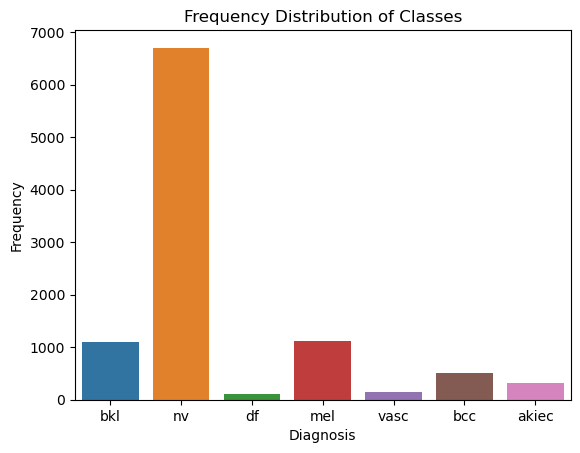

In [12]:
sns.countplot(x = 'dx', data = data)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')

Text(0.5, 1.0, 'Frequency Distribution of Gender')

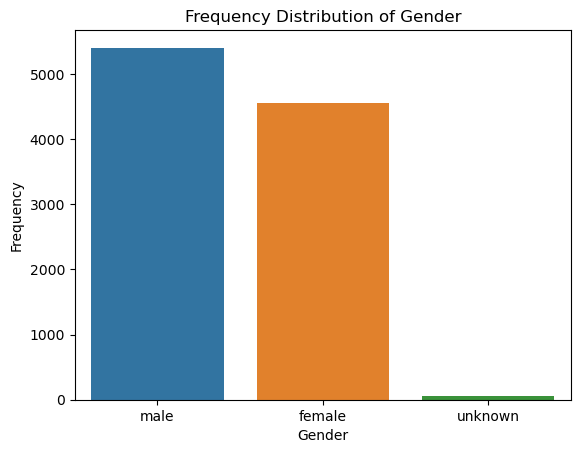

In [13]:
sns.countplot(x = 'sex', data = data)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Gender')

Text(0.5, 1.0, 'Frequency Distribution of Ages')

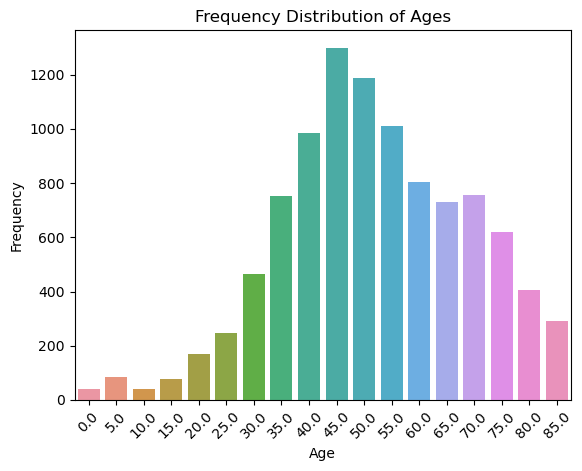

In [14]:
sns.countplot(x = 'age', data = data)
plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Ages')

Text(0.5, 1.0, 'Frequency Distribution of Location')

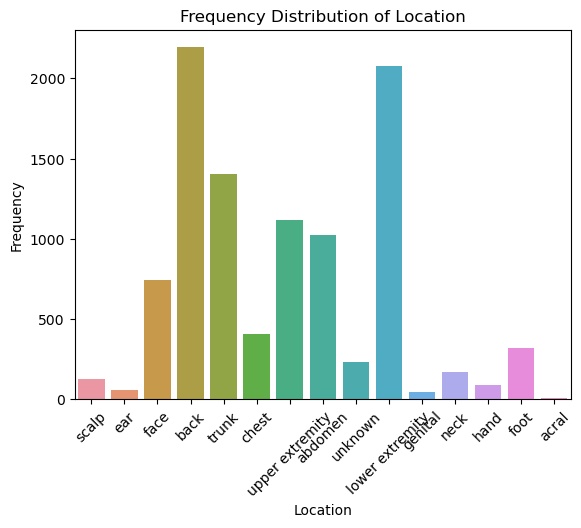

In [15]:
sns.countplot(x = 'localization', data = data)
plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Location')

In [16]:
data_img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
print('shape: ',data_img.shape)
print('column names: ',data_img.columns)

shape:  (10015, 2353)
column names:  Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009',
       ...
       'pixel2343', 'pixel2344', 'pixel2345', 'pixel2346', 'pixel2347',
       'pixel2348', 'pixel2349', 'pixel2350', 'pixel2351', 'label'],
      dtype='object', length=2353)


In [18]:
from tensorflow.keras.utils import to_categorical
y = data_img['label']
y = to_categorical(y)

import scipy.ndimage
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
X = data_img.drop(columns = ['label'])
X = np.array(X).reshape(-1,28,28,3)
t = np.zeros([len(X), 32, 32, 3],dtype=np.float32)
for i in range(len(X)):
    t[i] = scipy.ndimage.zoom(X[i],32/28)
X = np.array(t).reshape(-1,32,32,3)
X = vgg_preprocess(X)/255

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2023)

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D , MaxPooling2D , BatchNormalization, Activation, Flatten ,  GlobalAveragePooling2D, Dense ,  Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping

In [20]:
from tensorflow.keras.applications import VGG16

IMAGE_SIZE = 32

def model_vgg16(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7):
    input_tensor = Input(shape=in_shape)
    
    base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    x = Dense(128, activation='relu', name='fc1')(x)
    output = Dense(n_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model



In [21]:
model = model_vgg16(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 100,
                    callbacks=[rlr_cb, ely_cb])

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_test_labels = []
for i in y_test:
    y_test_labels.append(np.argmax(i))

from sklearn import metrics

print ("Accuracy : ", metrics.accuracy_score(y_test_labels,y_pred_labels))         # Evaulating predictions with test labels
print ("Report : ",  metrics.classification_report(y_test_labels, y_pred_labels))

confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()

X_over = data_img.drop(columns = ['label'])
y_over = data_img['label']

X_over,y_over  = oversample.fit_resample(X_over,y_over)
X_over = np.array(X_over).reshape(-1,28,28,3)
print('Shape of X :',X_over.shape)

sns.histplot(y_over)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')

In [ ]:
t = np.zeros([len(X_over), 32, 32, 3],dtype=np.float32)
for i in range(len(X_over)):
    t[i] = scipy.ndimage.zoom(X_over[i],32/28)
X_over = np.array(t).reshape(-1,32,32,3)
X_over = vgg_preprocess(X_over)/255

X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size=0.2, random_state=2023)

model = model_vgg16(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 100,
                    callbacks=[rlr_cb, ely_cb])